# Lab 10 - Deep Learning
- **Author:** Emily Aiken ([emilyaiken@berkeley.edu](mailto:emilyaiken@berkeley.edu))
- **Date:** April 6, 2022
- **Course:** INFO 251: Applied machine learning

## Topics:
1. Neural network regularization
2. Convolutional neural networks

## Learning Goals:
At the end of this lab, you will...
- Know how to code up L1 and L2 regularization in keras
- Know how and when to use dropout layers
- Understand the structure of convolutional neural networks
- Know the key hyperparameters of convolutional neural networks

## Resources:
- [L1 and L2 regularization in Keras](https://keras.io/api/layers/regularizers/)
- [Keras dropout layer](https://keras.io/api/layers/regularization_layers/dropout/)
- [Keras convolutional layers](https://keras.io/api/layers/convolution_layers/)
- [Keras pooling layers](https://keras.io/api/layers/pooling_layers/)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, roc_auc_score, accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.regularizers import l1, l2
import tensorflow as tf

## I. Regularization

#### Load Boston Housing data

In [2]:
# Data
data = datasets.load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
# Standardize the data
for col in df.columns:
    if col != 'target':
        mean, std = df[col].mean(), df[col].std()
        df[col] = (df[col] - mean)/std

In [4]:
# Split data into training and test
train, test = train_test_split(df, shuffle=True, test_size=0.25, random_state=0)
x_train, y_train = train.drop('target', axis=1), train['target']
x_test, y_test = test.drop('target', axis=1), test['target']

#### Neural network without regularization

In [5]:
# Random seeds
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

# Define NN
model = Sequential()
model.add(Dense(100, input_dim=len(x_train.columns), activation='relu'))
model.add(Dense(50, activation='relu')) 
model.add(Dense(1, activation='linear')) 
model.compile(loss='mse', optimizer='adam', metrics=['mse']) 

# Fit and predict with NN
model.fit(x_train, y_train, epochs=200, batch_size=5, verbose=0)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

# Get metrics
print('r2 on training set: %.2f' % r2_score(y_train, yhat_train))
print('r2 on test set: %.2f' % r2_score(y_test, yhat_test))

r2 on training set: 0.99
r2 on test set: 0.81


#### L1 and L2 regularization

In [6]:
# TODO: Experiment with adding L1 or L2 regularization to the hidden layers. Try values for lambda of 0.01, 0.1, 
# and 1. Can you improve the test set r2 score?
# HINT: Read https://keras.io/api/layers/regularizers/

#### Dropout

In [7]:
# TODO: Experiment with adding dropout layers after each of the hidden layers. Experiment with different dropout
# probabilities. Can you improve the test r2 score? 
# HINT: Read https://keras.io/api/layers/regularization_layers/dropout/

## II. Convolutional Neural Networks
#### Load MNIST data
- Notice: All images are the same size
- Notice: Images are in greyscale --> only one channel for CNN

In [8]:
# Load data
digits = datasets.load_digits()

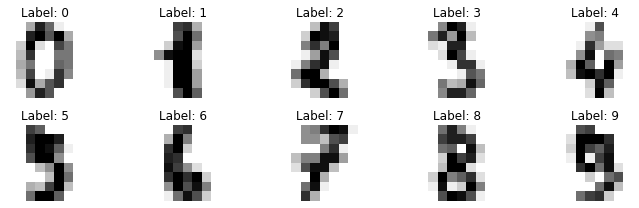

In [9]:
# Show some of the images
fig, ax = plt.subplots(2, 5, figsize=(10, 3))
ax = ax.flatten()
for a, image, label in zip(ax, digits.images, digits.target):
    a.set_axis_off()
    a.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    a.set_title("Label: %i" % label)
plt.tight_layout()
plt.show()

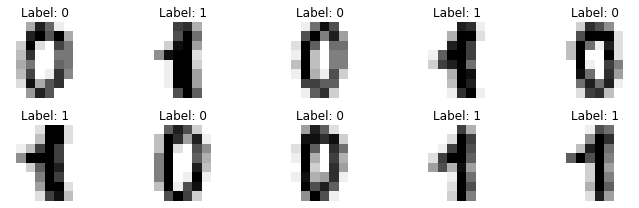

In [10]:
# Restrict to two classes -- we'll just look for the difference between 0 and 1
twos_threes = np.where((digits.target == 0) | (digits.target == 1))
x = digits.images[twos_threes]
y = digits.target[twos_threes]

fig, ax = plt.subplots(2, 5, figsize=(10, 3))
ax = ax.flatten()
for a, image, label in zip(ax, x, y):
    a.set_axis_off()
    a.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    a.set_title("Label: %i" % label)
plt.tight_layout()
plt.show()

In [11]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.25, random_state=0)

#### Preprocessing

In [12]:
# Standardization
mean_pixel = np.mean(x_train, axis=0)
std_pixel = np.std(x_train, axis=0) + 0.000000001
x_train = (x_train - mean_pixel)/std_pixel
x_test = (x_test - mean_pixel)/std_pixel

In [13]:
# Reshape train data
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

#### CNN

In [14]:
# Random seeds
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

model = Sequential()
model.add(Conv2D(filters=1, kernel_size=(2, 2), strides=1, activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

In [15]:
model.fit(x_train, y_train, epochs=100, batch_size=30, verbose=0)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

In [16]:
yhat_train_binary = yhat_train > 0.5
yhat_test_binary = yhat_test > 0.5

print('Accuracy score on training set: %.2f' % accuracy_score(y_train, yhat_train_binary))
print('Accuracy score on test set: %.2f' % accuracy_score(y_test, yhat_test_binary))
print('AUC score on training set: %.2f' % roc_auc_score(y_train, yhat_train))
print('AUC score on test set: %.2f' % roc_auc_score(y_test, yhat_test))

Accuracy score on training set: 0.99
Accuracy score on test set: 0.99
AUC score on training set: 1.00
AUC score on test set: 0.97


#### CNN tuning

In [17]:
# TODO: Tune the above CNN. Consider changing the convolutional filter, adding dropout layers, changing the 
# activiation functions, or changing the optimization strategy. Try to exceed 0.98 AUC on the test set. 